**Feature Detection/Matching Tutorial**

https://docs.opencv.org/4.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html

In [1]:
# one-time prep work
import numpy as np
import scipy.ndimage as sciimg
import matplotlib.pyplot as plt
# set matplotlib to render in this window, with the specified figure size
%matplotlib inline
import pylab
#pylab.rcParams['figure.figsize'] = (12.0, 8.0)
import cv2

In [2]:
# This function is in a read-only cell because we will use it again later.
def match_images(img1,img2,max_matches=None,orb_params={}):
    orb = cv2.ORB_create(**orb_params)
    # find the keypoints in each image
    kps1 = orb.detect(img1, None)
    kps2 = orb.detect(img2, None)

    kps1, des1 = orb.compute(img1,kps1)
    kps2, des2 = orb.compute(img2,kps2)
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des1,des2)
    # Sort them in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)
    # Keep only the requested number of matches
    matches = matches[:max_matches]
    return kps1, kps2, matches

In [140]:
tear_path = 'Images/tear_highres.jpg'
bow_path = 'Images/bow_highres.png'
test_path = 'TFT_GamePlay_still.png'
item_path = 'Images/tear_highres.jpg'
game_bow_path = 'tft_bow_char.png'
game_tear_path = 'tft_tear_inv.png'

#img = cv2.imread("the_book_thief.jpg", cv2.IMREAD_GRAYSCALE)
tear = cv2.cvtColor(cv2.imread(tear_path), cv2.COLOR_BGR2RGB)
#tear = cv2.imread(tear_path, cv2.IMREAD_GRAYSCALE)
test_img = cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB)
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)


game = cv2.cvtColor(cv2.imread(test_path), cv2.COLOR_BGR2RGB)

item = cv2.cvtColor(cv2.imread(game_tear_path), cv2.COLOR_BGR2RGB)


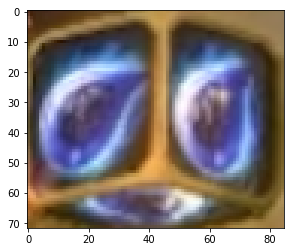

In [137]:
#game[top:bot, left:right]
#bow image params
#top = 180
#bot = 209
#left = 424
#right = 451
left = 75
right = 160
top = 58
bot = 130

item = item[top:bot, left:right]

plt.imshow(item)
#plt.imshow(game[top:bot, left:right])

**Contours as Features**

REF: https://docs.opencv.org/3.4.0/d4/d73/tutorial_py_contours_begin.html

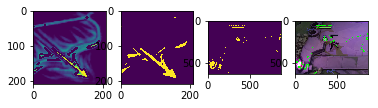

In [36]:
#Contours work better with binary images, so we'll gray-out the item/game images
itemgray = cv2.cvtColor(item.copy(), cv2.COLOR_BGR2GRAY)
#Apply a threshold on the image 
ret, thresh = cv2.threshold(itemgray, 127, 255, 0)
#Find the contours based on thresholds
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(itemgray, contours, -1, (0,255,0), 3)

#make a dummy output image so we don't alter the original
out_img = game.copy()

ret, thresh2 = cv2.threshold(cv2.cvtColor(game.copy(), cv2.COLOR_RGB2GRAY), 127, 255, 0)
c, h = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img2 = cv2.drawContours(out_img, c, -1, (0,255,0), 3)


plt.subplot(141)
plt.imshow(img)

plt.subplot(142)
plt.imshow(thresh)

plt.subplot(143)
plt.imshow(thresh2)

plt.subplot(144)
plt.imshow(img2)

**Orb Detection**


Ref: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8346440  <-- ORB, KAZE, AKAZE, SURF, etc.

Keypoints detected:  322


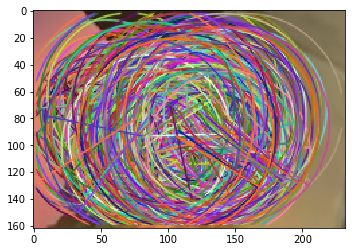

In [141]:
#Instantiate feature detector

pSize = 70
fThresh = 21

orb = cv2.ORB_create(nfeatures=10000, scoreType=2, patchSize=pSize, fastThreshold = fThresh)

keypoints_orb, descriptors = orb.detectAndCompute(item, None)

outImg = item.copy()
cv2.drawKeypoints(item, keypoints_orb, outImage=outImg, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

print("Keypoints detected: ", len(keypoints_orb))
#print(keypoints_orb)
plt.imshow(outImg)

322 10000


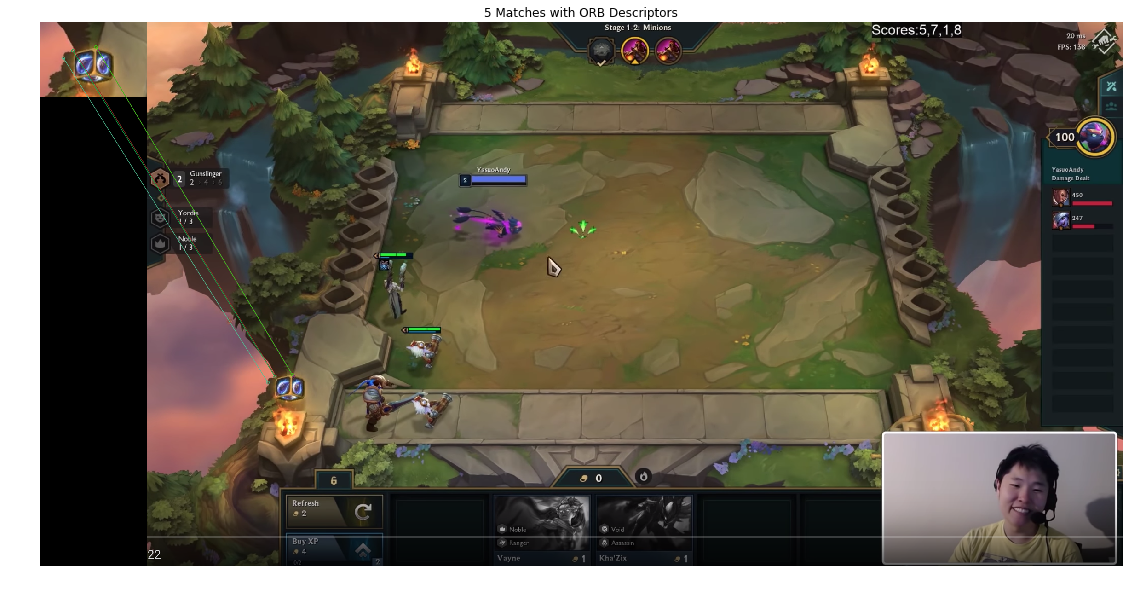

In [143]:
kps1, kps2, matches = match_images(item, game, 5, orb_params={'nfeatures':10000, 'patchSize':pSize, 'fastThreshold':fThresh})

print(len(kps1),len(kps2))

#plt.subplot(121)
#plt.imshow(tear)
#plt.subplot(122)


plt.figure(figsize=(20,10))
#DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
img3 = cv2.drawMatches(item,kps1,game,kps2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3), plt.axis('off'),  plt.title("{} Matches with ORB Descriptors".format(len(matches))),plt.show();


**Template Matching**

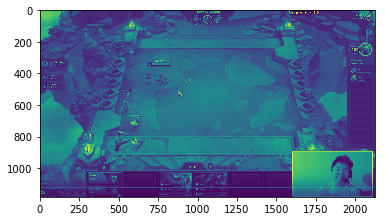

In [139]:
# Perform match operations. 
img_gray = cv2.cvtColor(game, cv2.COLOR_RGB2GRAY)
template = cv2.cvtColor(item, cv2.COLOR_RGB2GRAY)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_gray, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

#print(np.where(res >= 0.2))
    
plt.imshow(img_gray)
#cv2.imwrite('res.png',img_rgb)

Doesn't seem to work because the bow in the picture is scaled

**Affine Invariant Feature Extraction**

Ref: https://docs.opencv.org/3.3.0/d7/d7a/group__xfeatures2d__experiment.html
    https://docs.opencv.org/4.1.0/d4/db2/classcv_1_1xfeatures2d_1_1AffineFeature2D.html
        

In [ ]:
aff_det = cv2.xfeatures2d.HarrisLaplaceFeatureDetector_create()
aff = cv2.xfeatures2d.AffineFeature2D()

32
(12, 32)


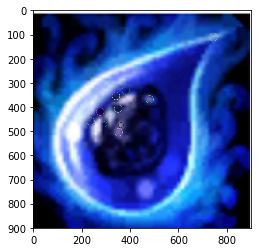

In [17]:
img = tear.copy()
# Initiate FAST detector
star = cv2.xfeatures2d.StarDetector_create()
# Initiate BRIEF extractor
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
# find the keypoints with STAR
kp = star.detect(img,None)
# compute the descriptors with BRIEF
kp, des = brief.compute(img, kp)
print( brief.descriptorSize() )
print( des.shape )

cv2.drawKeypoints(tear, kp, outImage=img, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
plt.imshow(img)